# Innitialize

In [1]:
import os
from google.colab import userdata
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['GIT_TOKEN'] = userdata.get('GIT_TOKEN')

In [2]:
import copy

In [3]:
!git clone https://$GIT_TOKEN@$repo
!kaggle competitions download -c aml-competition
!unzip -o aml-competition.zip -d data
!git clone https://github.com/Mamiglia/challenge.git

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train/Images/4945997009.jpg  
  inflating: data/train/train/Images/4946004444.jpg  
  inflating: data/train/train/Images/4946023775.jpg  
  inflating: data/train/train/Images/4946045875.jpg  
  inflating: data/train/train/Images/4946160196.jpg  
  inflating: data/train/train/Images/4946245832.jpg  
  inflating: data/train/train/Images/494625641.jpg  
  inflating: data/train/train/Images/4946401409.jpg  
  inflating: data/train/train/Images/4946431326.jpg  
  inflating: data/train/train/Images/4946877047.jpg  
  inflating: data/train/train/Images/4946968361.jpg  
  inflating: data/train/train/Images/4946977529.jpg  
  inflating: data/train/train/Images/4946986337.jpg  
  inflating: data/train/train/Images/4947072825.jpg  
  inflating: data/train/train/Images/4947153201.jpg  
  inflating: data/train/train/Images/4947321869.jpg  
  inflating: data/train/train/Images/4947854878.jpg  
  inflating: data/train/train/Im

In [4]:
from typing import List
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm.auto import tqdm
import torch.nn.functional as F
import numpy as np
from enum import Enum
import math
import random
import matplotlib.pyplot as plt

In [5]:
from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import visualize_retrieval, evaluate_retrieval
from challenge.src.eval.metrics import recall_at_k, ndcg,mrr

In [6]:
%pip install optuna

In [7]:
import optuna

In [8]:
!pip install torchdiffeq

In [9]:
def set_seed(seed=42):
    """Ensure deterministic reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed()

In [10]:
WORKING_DIR = Path.cwd()

In [11]:
MODELS_DIR = Path("/").absolute()
MODEL_PATH = MODELS_DIR / "default.pth"

In [12]:
DATA_PATH = WORKING_DIR / "data"

In [13]:
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
!git clone https://github.com/qihao067/CrossFlow.git

fatal: destination path 'CrossFlow' already exists and is not an empty directory.


In [15]:
sys.path.append(str(WORKING_DIR / "CrossFlow"))
from CrossFlow.diffusion.flow_matching import ClipLoss, SigLipLoss

# Actuall code

## Basic definitions

In [16]:
class Statistics():
  losses = []
  best_loss = float("inf")
  best_epoch_index = -1
  mse_losses = []
  cos_losses = []
  contrastive_losses = []

In [17]:
class DataKeeper():
  train_data = None
  train_loader = None
  val_loader = None
  train_dataset = None
  val_dataset = None
  val_caption_text = None
  val_text_embd = None
  val_img_file = None
  val_img_embd = None
  val_label = None
  def create_loaders(self, batch_size = BATCH_SIZE):
    self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
    self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size)

In [18]:
def get_train_data(data_path=DATA_PATH, split_ratio = 0.8, batch_size = BATCH_SIZE):
  data_keeper = DataKeeper()
  data_keeper.train_data = load_data(data_path/"train/train/train.npz")
  X, y, label = prepare_train_data(data_keeper.train_data)
  DATASET_SIZE = len(X)
  train_size = int(DATASET_SIZE * split_ratio)
  TRAIN_SPLIT = torch.zeros(len(X), dtype=bool)
  TRAIN_SPLIT[:train_size] = True
  X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
  y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]
  data_keeper.train_dataset = TensorDataset(X_train, y_train)
  data_keeper.val_dataset = TensorDataset(X_val, y_val)
  data_keeper.train_loader = DataLoader(data_keeper.train_dataset, batch_size=batch_size, shuffle=True)
  data_keeper.val_loader = DataLoader(data_keeper.val_dataset, batch_size=batch_size)
  img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
  data_keeper.val_caption_text = data_keeper.train_data['captions/text'][~TRAIN_SPLIT]
  data_keeper.val_text_embd = X_val
  data_keeper.img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
  data_keeper.val_img_file = data_keeper.train_data['images/names'][img_VAL_SPLIT]
  data_keeper.val_img_embd = torch.from_numpy(data_keeper.train_data['images/embeddings'][img_VAL_SPLIT])
  data_keeper.val_label = np.nonzero(data_keeper.train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]
  return data_keeper


In [19]:
def save_model(model, path=MODEL_PATH, verbose=True):
  torch.save(model.state_dict(), path)
  print(f"Model saved to {path}")

In [20]:
def load_model(model, path=MODEL_PATH, verbose=True):
  model.load_state_dict(torch.load(path))
  if verbose:
    print(f"Model loaded from {path}")
  return model

In [21]:
def sample_and_visualize(model, data_keeper, device=DEVICE, number_of_indices=5, dataset_path=WORKING_DIR/"data/train/train"):
  for i in range(0, number_of_indices):
    index = np.random.randint(0, 100)
    caption_embd = data_keeper.val_text_embd[index]
    caption_text = data_keeper.val_caption_text[index]
    gt_index = data_keeper.val_label[index]
    model.eval()
    with torch.no_grad():
      pred_embds = model(caption_embd.to(device)).to(device)
      visualize_retrieval(
        pred_embds,
        gt_index,
        data_keeper.val_img_file,
        caption_text, data_keeper.val_img_embd, k=5, dataset_path=dataset_path)


In [22]:
@torch.inference_mode()
def evaluate_retrieval(translated_embd, image_embd, gt_indices, max_indices = 99, batch_size=100):
    """
    [FIXED VERSION of challenge/src/eval/eval.py]
    This function had a bug in the repo, it's fixed here.
    """
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float()
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float()

    n_queries = translated_embd.shape[0]
    all_sorted_indices = []

    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]

        batch_similarity = batch_translated @ image_embd.T

        # --- THIS IS THE FIX ---
        # Added .cpu() before .numpy()
        batch_indices = batch_similarity.topk(k=max_indices, dim=1, sorted=True).indices.cpu().numpy()
        # --- END OF FIX ---

        all_sorted_indices.append(batch_indices)

    sorted_indices = np.concatenate(all_sorted_indices, axis=0)
    metrics = {
        'mrr': mrr,
        'ndcg': ndcg,
        'recall_at_1': lambda preds, gt: recall_at_k(preds, gt, 1),
        'recall_at_3': lambda preds, gt: recall_at_k(preds, gt, 3),
        'recall_at_5': lambda preds, gt: recall_at_k(preds, gt, 5),
        'recall_at_10': lambda preds, gt: recall_at_k(preds, gt, 10),
        'recall_at_50': lambda preds, gt: recall_at_k(preds, gt, 50),
    }

    results = {
        name: func(sorted_indices, gt_indices)
        for name, func in metrics.items()
    }

    return results

## Model deffinitions

In [23]:
class Normalization(Enum):
  NONE = 0
  STANDARD = 1
  L2 = 2

In [24]:
class AnchorSelectionStrategy(Enum):
  UNIFORM=1
  RANDOM=2

In [25]:
class RefinementType(Enum):
  NONE = 0,
  RESIDUAL=1

In [26]:
N_ANCHORS = 1536
ANCHOR_SELECTION =  AnchorSelectionStrategy.UNIFORM

NORMALIZATIONS = [Normalization.STANDARD, Normalization.L2]

USE_REFINEMENT = True
REFINEMENT_EPOCHS = 30
REFINEMENT_LR = 5e-5
REFINEMENT_BATCH_SIZE = 256
REFINEMENT_PATIENCE = 8

PROCRUSTES_METHOD = RefinementType.RESIDUAL
USE_ENSEMBLE = False

In [27]:
def normalize_embeddings(X, method=Normalization.STANDARD, stats=None):
    if method == Normalization.NONE:
        return X, {'method': 'none', 'dim': X.shape[1]}
    elif method == Normalization.L2:
        norms = torch.linalg.norm(X, axis=1, keepdims=True)
        norms = torch.where(norms == 0, 1.0, norms)
        X_norm = X / norms

        if stats is None:
            stats = {
                'method': 'l2',
                'dim': X.shape[1]
            }
        return X_norm, stats

    elif method == Normalization.STANDARD:
        if stats is None:
            mean = X.mean(axis=0)
            std = X.std(axis=0)
            std = torch.where(std == 0, 1.0, std)

            stats = {
                'method': 'standard',
                'mean': mean,
                'std': std,
                'dim': X.shape[1]
            }
        else:
            mean = stats['mean']
            std = stats['std']
        X_norm = (X - mean) / std
        return X_norm, stats


In [28]:
def select_anchors_diverse(data_keeper, n_anchors, method=AnchorSelectionStrategy.UNIFORM):
    caption_embeddings = data_keeper.train_data['captions/embeddings']
    label_matrix = data_keeper.train_data['captions/label']

    n_captions = len(caption_embeddings)
    gt_indices = np.argmax(label_matrix, axis=1)

    if method == AnchorSelectionStrategy.UNIFORM:
        caption_indices = np.linspace(0, n_captions - 1, n_anchors, dtype=int)

    elif method == AnchorSelectionStrategy.RANDOM:
        caption_indices = np.random.choice(n_captions, n_anchors, replace=True)

    else:
        raise ValueError(f"Unknown method: {method}")

    image_indices = gt_indices[caption_indices]

    print(f"   Selected {len(caption_indices)} anchor pairs")
    print(f"   Caption indices range: {caption_indices.min()} - {caption_indices.max()}")
    print(f"   Image indices range: {image_indices.min()} - {image_indices.max()}")

    return caption_indices, image_indices

In [29]:
def denormalize_embeddings(X_norm, method=Normalization.STANDARD, stats=None):
    if method == Normalization.NONE:
        return X_norm

    elif method == Normalization.L2:
        return X_norm

    elif method == Normalization.STANDARD:
        if stats is None:
            raise ValueError("Need stats for denormalization")
        mean = stats['mean']
        std = stats['std']
        if X_norm.shape[1] > len(mean):
            X_norm = X_norm[:, :len(mean)]
        X = X_norm * std + mean

        return X

In [30]:
def compute_R(R, allow_reflection=True):
    U, S, Vt = torch.linalg.svd(R, full_matrices=False)
    new_R = U @ Vt
    print(f"Xpad.shape {R.shape}")
    print(f"U.shape {U.shape}")
    print(f"Vt.shape {Vt.shape}")
    print(f"new_R.shape {new_R.shape}")
    if not allow_reflection and np.linalg.det(new_R) < 0:
        print("  ⚠ Reflection detected, correcting to pure rotation")
        U[:, -1] *= -1
        new_R = U @ Vt

    return new_R

In [31]:
def compute_procrustes_with_padding(X, Y, allow_reflection=True):
    d1, d2 = X.shape[1], Y.shape[1]
    d_max = max(d1, d2)
    print(f"X.shape {X.shape}")
    print(f"Y.shape {Y.shape}")
    if d1 < d_max:
        X = F.pad(X, (0, d_max - d1, 0, 0), mode='constant', value=0)
    if d2 < d_max:
        Y = F.pad(Y, (0, d_max - d2, 0, 0), mode='constant', value=0)
    H = X.T @ Y
    U, S, Vt = torch.linalg.svd(H, full_matrices=False)
    R = U @ Vt
    if not allow_reflection and np.linalg.det(R) < 0:
        print("  ⚠ Reflection detected, correcting to pure rotation")
        U[:, -1] *= -1
        R = U @ Vt

    return R

In [32]:
class ProcrustesTranslator(nn.Module):
  def __init__(self, normalization=Normalization.STANDARD, allow_reflection=True):
    super().__init__()
    self.normalization = normalization
    self.R = None
    self.source_stats = None
    self.target_stats = None
    self.allow_reflection = allow_reflection
  def fit(self, X_source, Y_target):
      print(f"  Input dimensions: {X_source.shape[1]} -> {Y_target.shape[1]}")

      X_norm, self.source_stats = normalize_embeddings(
          X_source, self.normalization
      )
      Y_norm, self.target_stats = normalize_embeddings(
          Y_target, self.normalization
      )

      self.R = compute_procrustes_with_padding(
          X_norm, Y_norm, allow_reflection=self.allow_reflection
      )

      print(f"  Transformation matrix shape: {self.R.shape}")

  def forward(self, X_source):
      if self.R is None:
          raise ValueError("Must call fit() before transform()")

      X_norm, _ = normalize_embeddings(
          X_source, self.normalization, self.source_stats
      )
      d_in = X_norm.shape[1]
      d_R = self.R.shape[0]

      if d_in < d_R:
          X_norm = F.pad(X_norm, (0, d_R - d_in, 0, 0), mode='constant')

      Y_norm = X_norm @ self.R

      # Step 4: Remove padding from output if needed
      # target_stats will tell us the original target dimension
      if self.normalization == Normalization.STANDARD:
          d_target = len(self.target_stats['mean'])
      elif self.normalization == Normalization.L2:
          d_target = self.target_stats['dim']
      else:
          d_target = d_R

      if Y_norm.shape[1] > d_target:
          Y_norm = Y_norm[:, :d_target]

      Y = denormalize_embeddings(
          Y_norm, self.normalization, self.target_stats
      )

      return Y

In [33]:
class AffineTranslator(nn.Module):
  def __init__(self, input_dim=1024, output_dim=1536, normalization=Normalization.STANDARD):
    super().__init__()
    self.normalization=Normalization.STANDARD
    self.net = nn.Linear(input_dim, output_dim)

  def forward(self, X):
    X_norm, self.source_stats = normalize_embeddings(
    X, self.normalization
    )
    Y = self.net(X_norm)
    return Y

In [34]:
class LinearTranslator(nn.Module):
  def __init__(self, input_dim=1024, output_dim=1536, normalization=Normalization.STANDARD):
    super().__init__()
    self.R = None
    self.normalization = normalization
  def fit(self, X,Y):
    X_norm, self.source_stats = normalize_embeddings(
        X, self.normalization
    )
    Y_norm, self.target_stats = normalize_embeddings( ###NOTE: MAybe it is nice idea ot to noramlzie Y, with L2?
        Y, self.normalization
    )
    R_T, residuals, rank, singular_values = torch.linalg.lstsq(X_norm, Y_norm)
    self.R = R_T
    return self.R
  def forward(self, X):
    X_norm, _ = normalize_embeddings(
          X, self.normalization, self.source_stats
      )
    Y_norm =   X_norm @ self.R
    Y = denormalize_embeddings(
      Y_norm, self.normalization, self.target_stats
      )
    return Y

In [35]:
class LOrthoTranslator(nn.Module):
  def __init__(self, normalization=Normalization.STANDARD, target_stats=None, allow_reflection=True):
    super().__init__()
    self.normalization = normalization
    self.R = None
    self.source_stats = None
    self.target_stats = target_stats
    self.allow_reflection = allow_reflection
  def fit(self, R):
      self.R = compute_R(
         R, allow_reflection=self.allow_reflection
      )

      print(f"  Transformation matrix shape: {self.R.shape}")

  def forward(self, X_source):
      if self.R is None:
          raise ValueError("Must call fit() before transform()")

      X_norm, _ = normalize_embeddings(
          X_source, self.normalization, self.source_stats
      )
      d_in = X_norm.shape[1]
      d_R = self.R.shape[0]

      if d_in < d_R:
          X_norm = F.pad(X_norm, (0, d_R - d_in, 0, 0), mode='constant')


      Y_norm = X_norm @ self.R

      if self.normalization == Normalization.STANDARD:
          d_target = len(self.target_stats['mean'])
      elif self.normalization == Normalization.L2:
          d_target = self.target_stats['dim']
      else:
          d_target = d_R

      if Y_norm.shape[1] > d_target:
          Y_norm = Y_norm[:, :d_target]

      Y = denormalize_embeddings(
          Y_norm, self.normalization, self.target_stats
      )

      return Y

In [36]:
class RefinedProcrustesTranslator(nn.Module):
    def __init__(self, d_in=1024, d_out=1536, procrustes_R=None,
                 hidden_dim=None, refinement_type=RefinementType.RESIDUAL):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = d_out

        self.d_in = d_in
        self.d_out = d_out
        self.refinement_type = refinement_type

        if procrustes_R is not None:
            R_sub = procrustes_R[:d_out, :d_in]

            self.linear = nn.Linear(d_in, d_out, bias=False)
            with torch.no_grad():
                self.linear.weight.data = R_sub

            print(f"  Initialized with Procrustes solution (extracted {d_out}×{d_in} from {procrustes_R.shape})")

        if refinement_type == RefinementType.RESIDUAL:
            self.refinement = nn.Sequential(
                nn.Linear(d_out, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.LayerNorm(hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim // 2, d_out)
            )
            # Initialize last layer near zero
            nn.init.zeros_(self.refinement[-1].weight)
            nn.init.zeros_(self.refinement[-1].bias)
            self.residual_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        x_proj = self.linear(x)

        if self.refinement_type == RefinementType.RESIDUAL:
            residual = self.refinement(x_proj)
            alpha = torch.sigmoid(self.residual_weight) * 0.3 ##NOTE is this ).3 needed?
            return x_proj + alpha * residual
        else:
            return x_proj

In [37]:
def train_translator(translator, data_keeper, n_anchors=N_ANCHORS, method=ANCHOR_SELECTION):
  caption_anchor_idx, image_anchor_idx = select_anchors_diverse(data_keeper, n_anchors, method=method)
  X_anchors = torch.from_numpy(data_keeper.train_data['captions/embeddings'][caption_anchor_idx]).float().to(DEVICE)
  Y_anchors = torch.from_numpy(data_keeper.train_data['images/embeddings'][image_anchor_idx]).float().to(DEVICE)
  translator.fit(X_anchors, Y_anchors)


In [38]:
def model_metrics(model, data_keeper, batch_size=BATCH_SIZE, device=DEVICE):
  all_embds = []
  for X, y in data_keeper.val_loader:
    model.eval()
    model.to(device)
    with torch.no_grad():
      pred_embds = model(X.to(device))
      all_embds.append(pred_embds)
  all_embds = torch.cat(all_embds, dim=0)
  val_img_embd_on_device = data_keeper.val_img_embd.to(device)
  return evaluate_retrieval(all_embds, val_img_embd_on_device, data_keeper.val_label)

In [39]:
def create_submision(model, data_keeper, batch_size=64, data_path=DATA_PATH, device=DEVICE):
  test_data = load_data(data_path/"test/test/test.clean.npz")
  test_embds = torch.from_numpy(test_data['captions/embeddings']).to(device)
  all_preds = torch.empty((0, 1536), device=device)
  model.eval()
  for i in range(0, len(test_embds), batch_size):
    batch = test_embds[i:min(i+batch_size, len(test_embds))]
    with torch.no_grad():
      pred_embds = model(batch)
    all_preds = torch.cat((all_preds, pred_embds),dim=0)
  pred_embds = torch.Tensor(all_preds)

  submision = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
  return pred_embds

In [40]:

def train_model_affine(model, train_loader, epochs=EPOCHS, device=DEVICE, lr=LR, loss_function=F.mse_loss, verbose = True, collect_statistiscs = True):
  optimizer  = optim.Adam(model.parameters(), lr=lr)
  best_val_loss = float("inf")
  training_statistic = None
  if collect_statistiscs:
    training_statistic = Statistics()
  for epoch in tqdm(range(epochs), desc="Trainnig"):
    model.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") if verbose else train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs, y_batch)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    train_loss /= len(train_loader)
    if verbose:
      print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss}")
    if collect_statistiscs:
      training_statistic.losses.append(train_loss)
  if collect_statistiscs:
    training_statistic.best_loss = min(training_statistic.losses)
    training_statistic.best_epoch_index = training_statistic.losses.index(training_statistic.best_loss)
  return model, training_statistic

## Model training

In [41]:
data_keeper = get_train_data(split_ratio=0.9)

(125000,)
Train data: 125000 captions, 125000 images


In [42]:
ptranslator = ProcrustesTranslator(
    normalization=NORMALIZATIONS[1]
)
train_translator(ptranslator, data_keeper, n_anchors=120000)

   Selected 120000 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
  Input dimensions: 1024 -> 1536
X.shape torch.Size([120000, 1024])
Y.shape torch.Size([120000, 1536])
  Transformation matrix shape: torch.Size([1536, 1536])


In [43]:
metrics = model_metrics(ptranslator, data_keeper)
print(metrics)

{'mrr': np.float64(0.31543242941327815), 'ndcg': np.float64(0.43418439221071176), 'recall_at_1': 0.19776, 'recall_at_3': 0.35352, 'recall_at_5': 0.43832, 'recall_at_10': 0.56296, 'recall_at_50': 0.82464}


In [44]:
ltranslator = LinearTranslator(
    normalization=NORMALIZATIONS[1]
)
train_translator(ltranslator, data_keeper, n_anchors=120000)

   Selected 120000 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999


In [45]:
metrics = model_metrics(ltranslator, data_keeper)
print(metrics)

{'mrr': np.float64(0.17760477482086354), 'ndcg': np.float64(0.2928947796026094), 'recall_at_1': 0.08752, 'recall_at_3': 0.19208, 'recall_at_5': 0.2572, 'recall_at_10': 0.36864, 'recall_at_50': 0.65728}


In [46]:
lotranslator = LOrthoTranslator(
    normalization=NORMALIZATIONS[1],
    target_stats=ltranslator.target_stats
)
lotranslator.fit(ltranslator.R)

Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


In [47]:
metrics = model_metrics(lotranslator, data_keeper)
print(metrics)

{'mrr': np.float64(0.5092690757619192), 'ndcg': np.float64(0.6099382619579287), 'recall_at_1': 0.3704, 'recall_at_3': 0.58248, 'recall_at_5': 0.67744, 'recall_at_10': 0.78928, 'recall_at_50': 0.94536}


In [48]:
atranslator = AffineTranslator(normalization=NORMALIZATIONS[0]).to(DEVICE)

In [49]:
model, stats = train_model_affine(atranslator, data_keeper.train_loader, verbose=False)

Trainnig:   0%|          | 0/20 [00:00<?, ?it/s]

In [50]:
metrics = model_metrics(atranslator, data_keeper)
print(metrics)

{'mrr': np.float64(0.13569236931797782), 'ndcg': np.float64(0.2428586841188575), 'recall_at_1': 0.0608, 'recall_at_3': 0.14128, 'recall_at_5': 0.19848, 'recall_at_10': 0.29424, 'recall_at_50': 0.57592}


### Best model trainig

In [51]:
data_keeper = get_train_data(split_ratio=1.0)# suing whole dataset for training

(125000,)
Train data: 125000 captions, 125000 images


In [52]:
lotranslator = LOrthoTranslator(
    normalization=NORMALIZATIONS[1],
    target_stats=ltranslator.target_stats
)
lotranslator.fit(ltranslator.R)

Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


In [53]:
create_submision(lotranslator, data_keeper=data_keeper)

Generating submission file...
✓ Saved submission to submission.csv


tensor([[-0.0100, -0.0422,  0.0058,  ..., -0.0221,  0.0319, -0.0300],
        [ 0.0192, -0.0466, -0.0152,  ..., -0.0377, -0.0227,  0.0016],
        [-0.0077,  0.0192,  0.0415,  ...,  0.0360,  0.0033, -0.0051],
        ...,
        [ 0.0002,  0.0037,  0.0055,  ...,  0.0114,  0.0372,  0.0091],
        [-0.0773, -0.0449,  0.0663,  ..., -0.0294,  0.0228, -0.0049],
        [-0.0161,  0.0092,  0.0103,  ...,  0.0247, -0.0007,  0.0358]],
       device='cuda:0')

# optuna experiments used to find best params of model

In [56]:
data_keeper = get_train_data(split_ratio=0.9)

(125000,)
Train data: 125000 captions, 125000 images


In [57]:
def objective(trial):
    n_anchors =trial.suggest_int('n_anchors', 6000, 200000, step=1536)
    normalization = trial.suggest_categorical('normalization',[Normalization.STANDARD, Normalization.L2])
    # allow_reflection = trial.suggest_categorical('allow_reflection',[True, False])
    allow_reflection = True
    anchor_selection = trial.suggest_categorical('anchor_selection',[AnchorSelectionStrategy.RANDOM, AnchorSelectionStrategy.UNIFORM])
    ltranslator = LinearTranslator(
        normalization=normalization

    )

    train_translator(ltranslator, data_keeper, n_anchors=n_anchors, method=anchor_selection)
    lotranslator = LOrthoTranslator(
        normalization=normalization,
        target_stats=ltranslator.target_stats,
        allow_reflection=allow_reflection
    )
    lotranslator.fit(ltranslator.R)
    metrics = model_metrics(lotranslator, data_keeper)
    print(metrics)
    return metrics['mrr']

In [58]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

[I 2025-11-18 11:08:59,088] A new study created in memory with name: no-name-ddcb2235-6bda-49d1-9479-05a7abe36464
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [6000, 200000] and step=1536, but the range is not divisible by `step`. It will be replaced with [6000, 199536].
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Normalization.STANDARD which is of type Normalization.
  warnings.warn(message)
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Normalization.L2 which is of type Normalization.
  warnings.warn(message)
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:502: 

   Selected 122736 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:01,370] Trial 0 finished with value: 0.13165368839508934 and parameters: {'n_anchors': 122736, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 0 with value: 0.13165368839508934.


{'mrr': np.float64(0.13165368839508934), 'ndcg': np.float64(0.21367170843907107), 'recall_at_1': 0.07208, 'recall_at_3': 0.14104, 'recall_at_5': 0.18672, 'recall_at_10': 0.2552, 'recall_at_50': 0.45976}
   Selected 56688 anchor pairs
   Caption indices range: 0 - 124995
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:02,858] Trial 1 finished with value: 0.11438809134173218 and parameters: {'n_anchors': 56688, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 0 with value: 0.13165368839508934.


{'mrr': np.float64(0.11438809134173218), 'ndcg': np.float64(0.19166155976686663), 'recall_at_1': 0.06064, 'recall_at_3': 0.12192, 'recall_at_5': 0.15984, 'recall_at_10': 0.22176, 'recall_at_50': 0.41816}
   Selected 121200 anchor pairs
   Caption indices range: 1 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:05,208] Trial 2 finished with value: 0.4788836731984255 and parameters: {'n_anchors': 121200, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 2 with value: 0.4788836731984255.


{'mrr': np.float64(0.4788836731984255), 'ndcg': np.float64(0.5824994721834866), 'recall_at_1': 0.3436, 'recall_at_3': 0.5432, 'recall_at_5': 0.64072, 'recall_at_10': 0.75824, 'recall_at_50': 0.92896}
   Selected 193392 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:08,370] Trial 3 finished with value: 0.13000923840220824 and parameters: {'n_anchors': 193392, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 2 with value: 0.4788836731984255.


{'mrr': np.float64(0.13000923840220824), 'ndcg': np.float64(0.2116704696320988), 'recall_at_1': 0.07064, 'recall_at_3': 0.13976, 'recall_at_5': 0.18208, 'recall_at_10': 0.25368, 'recall_at_50': 0.45616}
   Selected 182640 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:11,399] Trial 4 finished with value: 0.12736879981606286 and parameters: {'n_anchors': 182640, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 2 with value: 0.4788836731984255.


{'mrr': np.float64(0.12736879981606286), 'ndcg': np.float64(0.2089852039570678), 'recall_at_1': 0.06896, 'recall_at_3': 0.13704, 'recall_at_5': 0.18056, 'recall_at_10': 0.2476, 'recall_at_50': 0.45288}
   Selected 87408 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:13,278] Trial 5 finished with value: 0.4996381562063536 and parameters: {'n_anchors': 87408, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 5 with value: 0.4996381562063536.


{'mrr': np.float64(0.4996381562063536), 'ndcg': np.float64(0.6016248650998279), 'recall_at_1': 0.3616, 'recall_at_3': 0.56928, 'recall_at_5': 0.66384, 'recall_at_10': 0.7804, 'recall_at_50': 0.93976}
   Selected 96624 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:15,275] Trial 6 finished with value: 0.12095701177973799 and parameters: {'n_anchors': 96624, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 5 with value: 0.4996381562063536.


{'mrr': np.float64(0.12095701177973799), 'ndcg': np.float64(0.2000198194814626), 'recall_at_1': 0.0648, 'recall_at_3': 0.1288, 'recall_at_5': 0.17112, 'recall_at_10': 0.23744, 'recall_at_50': 0.43216}
   Selected 64368 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:16,856] Trial 7 finished with value: 0.48820008993092817 and parameters: {'n_anchors': 64368, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 5 with value: 0.4996381562063536.


{'mrr': np.float64(0.48820008993092817), 'ndcg': np.float64(0.5916231799788035), 'recall_at_1': 0.3484, 'recall_at_3': 0.5624, 'recall_at_5': 0.65608, 'recall_at_10': 0.76864, 'recall_at_50': 0.93568}
   Selected 150384 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:19,515] Trial 8 finished with value: 0.5062212027808205 and parameters: {'n_anchors': 150384, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 8 with value: 0.5062212027808205.


{'mrr': np.float64(0.5062212027808205), 'ndcg': np.float64(0.6078277317362827), 'recall_at_1': 0.36656, 'recall_at_3': 0.5776, 'recall_at_5': 0.67632, 'recall_at_10': 0.79112, 'recall_at_50': 0.94536}
   Selected 88944 anchor pairs
   Caption indices range: 1 - 124997
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:21,457] Trial 9 finished with value: 0.47229132689361225 and parameters: {'n_anchors': 88944, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 8 with value: 0.5062212027808205.


{'mrr': np.float64(0.47229132689361225), 'ndcg': np.float64(0.5772095864065644), 'recall_at_1': 0.33448, 'recall_at_3': 0.5432, 'recall_at_5': 0.63264, 'recall_at_10': 0.75184, 'recall_at_50': 0.9244}
   Selected 153456 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:24,129] Trial 10 finished with value: 0.5091555333091315 and parameters: {'n_anchors': 153456, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.5091555333091315), 'ndcg': np.float64(0.609774052057831), 'recall_at_1': 0.37056, 'recall_at_3': 0.58512, 'recall_at_5': 0.67376, 'recall_at_10': 0.78632, 'recall_at_50': 0.94544}
   Selected 156528 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:26,846] Trial 11 finished with value: 0.506862345338466 and parameters: {'n_anchors': 156528, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.506862345338466), 'ndcg': np.float64(0.6080514138985416), 'recall_at_1': 0.368, 'recall_at_3': 0.58024, 'recall_at_5': 0.67736, 'recall_at_10': 0.7864, 'recall_at_50': 0.94568}
   Selected 158064 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:29,587] Trial 12 finished with value: 0.5076472491988613 and parameters: {'n_anchors': 158064, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.5076472491988613), 'ndcg': np.float64(0.6087839644394999), 'recall_at_1': 0.36864, 'recall_at_3': 0.58128, 'recall_at_5': 0.67576, 'recall_at_10': 0.78744, 'recall_at_50': 0.94384}
   Selected 154992 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:32,281] Trial 13 finished with value: 0.5064955202838399 and parameters: {'n_anchors': 154992, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.5064955202838399), 'ndcg': np.float64(0.6078098987129976), 'recall_at_1': 0.36696, 'recall_at_3': 0.58064, 'recall_at_5': 0.674, 'recall_at_10': 0.78704, 'recall_at_50': 0.94472}
   Selected 21360 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:33,349] Trial 14 finished with value: 0.4282401242738949 and parameters: {'n_anchors': 21360, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.4282401242738949), 'ndcg': np.float64(0.5379926957756284), 'recall_at_1': 0.29256, 'recall_at_3': 0.49024, 'recall_at_5': 0.58656, 'recall_at_10': 0.70752, 'recall_at_50': 0.90296}
   Selected 171888 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:36,272] Trial 15 finished with value: 0.5085148287868624 and parameters: {'n_anchors': 171888, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.5085148287868624), 'ndcg': np.float64(0.6093016097483839), 'recall_at_1': 0.36896, 'recall_at_3': 0.58304, 'recall_at_5': 0.6792, 'recall_at_10': 0.78944, 'recall_at_50': 0.94232}
   Selected 199536 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:39,602] Trial 16 finished with value: 0.508540603882062 and parameters: {'n_anchors': 199536, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.508540603882062), 'ndcg': np.float64(0.6094399640279013), 'recall_at_1': 0.36888, 'recall_at_3': 0.584, 'recall_at_5': 0.67704, 'recall_at_10': 0.7896, 'recall_at_50': 0.94392}
   Selected 199536 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:42,886] Trial 17 finished with value: 0.508540603882062 and parameters: {'n_anchors': 199536, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.508540603882062), 'ndcg': np.float64(0.6094399640279013), 'recall_at_1': 0.36888, 'recall_at_3': 0.584, 'recall_at_5': 0.67704, 'recall_at_10': 0.7896, 'recall_at_50': 0.94392}
   Selected 125808 anchor pairs
   Caption indices range: 10 - 124999
   Image indices range: 2 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:45,306] Trial 18 finished with value: 0.48770469357026186 and parameters: {'n_anchors': 125808, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.48770469357026186), 'ndcg': np.float64(0.5904061403005931), 'recall_at_1': 0.35, 'recall_at_3': 0.56104, 'recall_at_5': 0.64896, 'recall_at_10': 0.7668, 'recall_at_50': 0.93176}
   Selected 176496 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:48,301] Trial 19 finished with value: 0.5079868657714419 and parameters: {'n_anchors': 176496, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.5079868657714419), 'ndcg': np.float64(0.6089899473463434), 'recall_at_1': 0.36704, 'recall_at_3': 0.58576, 'recall_at_5': 0.68144, 'recall_at_10': 0.7884, 'recall_at_50': 0.94424}
   Selected 138096 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:50,819] Trial 20 finished with value: 0.5060580269406774 and parameters: {'n_anchors': 138096, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 10 with value: 0.5091555333091315.


{'mrr': np.float64(0.5060580269406774), 'ndcg': np.float64(0.6077009481971787), 'recall_at_1': 0.36568, 'recall_at_3': 0.58256, 'recall_at_5': 0.67528, 'recall_at_10': 0.78928, 'recall_at_50': 0.94552}
   Selected 198000 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:54,068] Trial 21 finished with value: 0.5097541644353824 and parameters: {'n_anchors': 198000, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 21 with value: 0.5097541644353824.


{'mrr': np.float64(0.5097541644353824), 'ndcg': np.float64(0.610473370895221), 'recall_at_1': 0.3716, 'recall_at_3': 0.58272, 'recall_at_5': 0.67592, 'recall_at_10': 0.78712, 'recall_at_50': 0.944}
   Selected 196464 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:09:57,295] Trial 22 finished with value: 0.5069371437058211 and parameters: {'n_anchors': 196464, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 21 with value: 0.5097541644353824.


{'mrr': np.float64(0.5069371437058211), 'ndcg': np.float64(0.6081634610196278), 'recall_at_1': 0.36704, 'recall_at_3': 0.58136, 'recall_at_5': 0.67688, 'recall_at_10': 0.78664, 'recall_at_50': 0.94568}
   Selected 173424 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:00,246] Trial 23 finished with value: 0.510644564801564 and parameters: {'n_anchors': 173424, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.510644564801564), 'ndcg': np.float64(0.6110532988183071), 'recall_at_1': 0.3732, 'recall_at_3': 0.58376, 'recall_at_5': 0.67728, 'recall_at_10': 0.78792, 'recall_at_50': 0.94568}
   Selected 171888 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:03,197] Trial 24 finished with value: 0.5085148287868624 and parameters: {'n_anchors': 171888, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5085148287868624), 'ndcg': np.float64(0.6093016097483839), 'recall_at_1': 0.36896, 'recall_at_3': 0.58304, 'recall_at_5': 0.6792, 'recall_at_10': 0.78944, 'recall_at_50': 0.94232}
   Selected 136560 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:05,717] Trial 25 finished with value: 0.5077779548804541 and parameters: {'n_anchors': 136560, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5077779548804541), 'ndcg': np.float64(0.6088825426079826), 'recall_at_1': 0.3676, 'recall_at_3': 0.58312, 'recall_at_5': 0.6772, 'recall_at_10': 0.78832, 'recall_at_50': 0.9456}
   Selected 181104 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:08,894] Trial 26 finished with value: 0.12704898810009185 and parameters: {'n_anchors': 181104, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.12704898810009185), 'ndcg': np.float64(0.20787206012981052), 'recall_at_1': 0.06912, 'recall_at_3': 0.13736, 'recall_at_5': 0.17632, 'recall_at_10': 0.24624, 'recall_at_50': 0.44704}
   Selected 165744 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:11,767] Trial 27 finished with value: 0.5057508293337015 and parameters: {'n_anchors': 165744, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5057508293337015), 'ndcg': np.float64(0.6070009679159865), 'recall_at_1': 0.36584, 'recall_at_3': 0.58232, 'recall_at_5': 0.67288, 'recall_at_10': 0.78648, 'recall_at_50': 0.94312}
   Selected 139632 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:14,324] Trial 28 finished with value: 0.507648821112577 and parameters: {'n_anchors': 139632, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.507648821112577), 'ndcg': np.float64(0.6086228385095475), 'recall_at_1': 0.3688, 'recall_at_3': 0.58088, 'recall_at_5': 0.67712, 'recall_at_10': 0.78944, 'recall_at_50': 0.94288}
   Selected 113520 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:16,702] Trial 29 finished with value: 0.13199267579148402 and parameters: {'n_anchors': 113520, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.13199267579148402), 'ndcg': np.float64(0.21389576478284195), 'recall_at_1': 0.07184, 'recall_at_3': 0.14264, 'recall_at_5': 0.18704, 'recall_at_10': 0.25472, 'recall_at_50': 0.45912}
   Selected 187248 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:19,841] Trial 30 finished with value: 0.5051173305046902 and parameters: {'n_anchors': 187248, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5051173305046902), 'ndcg': np.float64(0.6066630267007154), 'recall_at_1': 0.36584, 'recall_at_3': 0.57856, 'recall_at_5': 0.67376, 'recall_at_10': 0.78584, 'recall_at_50': 0.9436}
   Selected 188784 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:22,986] Trial 31 finished with value: 0.5052745097409438 and parameters: {'n_anchors': 188784, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5052745097409438), 'ndcg': np.float64(0.6068491299899622), 'recall_at_1': 0.36528, 'recall_at_3': 0.57944, 'recall_at_5': 0.674, 'recall_at_10': 0.7884, 'recall_at_50': 0.94432}
   Selected 168816 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:25,879] Trial 32 finished with value: 0.506545504241177 and parameters: {'n_anchors': 168816, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.506545504241177), 'ndcg': np.float64(0.6076741718593771), 'recall_at_1': 0.36832, 'recall_at_3': 0.57928, 'recall_at_5': 0.67424, 'recall_at_10': 0.7876, 'recall_at_50': 0.9436}
   Selected 187248 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:28,999] Trial 33 finished with value: 0.5051173305046902 and parameters: {'n_anchors': 187248, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5051173305046902), 'ndcg': np.float64(0.6066630267007154), 'recall_at_1': 0.36584, 'recall_at_3': 0.57856, 'recall_at_5': 0.67376, 'recall_at_10': 0.78584, 'recall_at_50': 0.9436}
   Selected 199536 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:32,371] Trial 34 finished with value: 0.12121041687325229 and parameters: {'n_anchors': 199536, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.12121041687325229), 'ndcg': np.float64(0.2013115755526531), 'recall_at_1': 0.06384, 'recall_at_3': 0.12904, 'recall_at_5': 0.1732, 'recall_at_10': 0.23712, 'recall_at_50': 0.43856}
   Selected 145776 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:34,993] Trial 35 finished with value: 0.5085584467568647 and parameters: {'n_anchors': 145776, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5085584467568647), 'ndcg': np.float64(0.6094318753912051), 'recall_at_1': 0.37016, 'recall_at_3': 0.58016, 'recall_at_5': 0.67584, 'recall_at_10': 0.7888, 'recall_at_50': 0.94624}
   Selected 113520 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:37,191] Trial 36 finished with value: 0.5094633415856098 and parameters: {'n_anchors': 113520, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.5094633415856098), 'ndcg': np.float64(0.6098257569765243), 'recall_at_1': 0.37136, 'recall_at_3': 0.5824, 'recall_at_5': 0.67464, 'recall_at_10': 0.78568, 'recall_at_50': 0.94384}
   Selected 105840 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:39,318] Trial 37 finished with value: 0.12412912144875415 and parameters: {'n_anchors': 105840, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 23 with value: 0.510644564801564.


{'mrr': np.float64(0.12412912144875415), 'ndcg': np.float64(0.20349257683968763), 'recall_at_1': 0.06712, 'recall_at_3': 0.1336, 'recall_at_5': 0.17208, 'recall_at_10': 0.24048, 'recall_at_50': 0.43608}
   Selected 124272 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:41,640] Trial 38 finished with value: 0.5106550856811051 and parameters: {'n_anchors': 124272, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 38 with value: 0.5106550856811051.


{'mrr': np.float64(0.5106550856811051), 'ndcg': np.float64(0.6114014856397358), 'recall_at_1': 0.37168, 'recall_at_3': 0.58352, 'recall_at_5': 0.67912, 'recall_at_10': 0.78968, 'recall_at_50': 0.94584}
   Selected 67440 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:43,254] Trial 39 finished with value: 0.12467153931985302 and parameters: {'n_anchors': 67440, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 38 with value: 0.5106550856811051.


{'mrr': np.float64(0.12467153931985302), 'ndcg': np.float64(0.2050921616795319), 'recall_at_1': 0.06688, 'recall_at_3': 0.13376, 'recall_at_5': 0.17536, 'recall_at_10': 0.24224, 'recall_at_50': 0.44104}
   Selected 49008 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:44,638] Trial 40 finished with value: 0.4844938093840344 and parameters: {'n_anchors': 49008, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 38 with value: 0.5106550856811051.


{'mrr': np.float64(0.4844938093840344), 'ndcg': np.float64(0.5872830328226629), 'recall_at_1': 0.35, 'recall_at_3': 0.55, 'recall_at_5': 0.64744, 'recall_at_10': 0.76096, 'recall_at_50': 0.93168}
   Selected 122736 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:46,938] Trial 41 finished with value: 0.5101404948633405 and parameters: {'n_anchors': 122736, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 38 with value: 0.5106550856811051.


{'mrr': np.float64(0.5101404948633405), 'ndcg': np.float64(0.6108924526369494), 'recall_at_1': 0.37136, 'recall_at_3': 0.58344, 'recall_at_5': 0.67752, 'recall_at_10': 0.79024, 'recall_at_50': 0.94512}
   Selected 127344 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:49,301] Trial 42 finished with value: 0.5108494633965874 and parameters: {'n_anchors': 127344, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5108494633965874), 'ndcg': np.float64(0.611462909989128), 'recall_at_1': 0.37216, 'recall_at_3': 0.5852, 'recall_at_5': 0.67704, 'recall_at_10': 0.7884, 'recall_at_50': 0.94608}
   Selected 127344 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:51,669] Trial 43 finished with value: 0.5108494633965874 and parameters: {'n_anchors': 127344, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5108494633965874), 'ndcg': np.float64(0.611462909989128), 'recall_at_1': 0.37216, 'recall_at_3': 0.5852, 'recall_at_5': 0.67704, 'recall_at_10': 0.7884, 'recall_at_50': 0.94608}
   Selected 125808 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:54,019] Trial 44 finished with value: 0.5100875461456059 and parameters: {'n_anchors': 125808, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5100875461456059), 'ndcg': np.float64(0.6109643356794207), 'recall_at_1': 0.37144, 'recall_at_3': 0.58312, 'recall_at_5': 0.67856, 'recall_at_10': 0.78864, 'recall_at_50': 0.9464}
   Selected 92016 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:55,959] Trial 45 finished with value: 0.5022572451593399 and parameters: {'n_anchors': 92016, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5022572451593399), 'ndcg': np.float64(0.6038376680454279), 'recall_at_1': 0.3644, 'recall_at_3': 0.5716, 'recall_at_5': 0.66792, 'recall_at_10': 0.78056, 'recall_at_50': 0.94192}
   Selected 105840 anchor pairs
   Caption indices range: 1 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:10:58,128] Trial 46 finished with value: 0.478370755763638 and parameters: {'n_anchors': 105840, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.478370755763638), 'ndcg': np.float64(0.5829001091027363), 'recall_at_1': 0.34136, 'recall_at_3': 0.54696, 'recall_at_5': 0.63952, 'recall_at_10': 0.75872, 'recall_at_50': 0.92944}
   Selected 130416 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:00,541] Trial 47 finished with value: 0.5107697897853605 and parameters: {'n_anchors': 130416, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5107697897853605), 'ndcg': np.float64(0.6113380228524736), 'recall_at_1': 0.37184, 'recall_at_3': 0.5872, 'recall_at_5': 0.67696, 'recall_at_10': 0.79128, 'recall_at_50': 0.94472}
   Selected 78192 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:02,315] Trial 48 finished with value: 0.4941326158704835 and parameters: {'n_anchors': 78192, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.4941326158704835), 'ndcg': np.float64(0.5969085086991698), 'recall_at_1': 0.35392, 'recall_at_3': 0.5684, 'recall_at_5': 0.66192, 'recall_at_10': 0.77552, 'recall_at_50': 0.93624}
   Selected 133488 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:04,788] Trial 49 finished with value: 0.5081040681226872 and parameters: {'n_anchors': 133488, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5081040681226872), 'ndcg': np.float64(0.609181629222519), 'recall_at_1': 0.36872, 'recall_at_3': 0.58024, 'recall_at_5': 0.67672, 'recall_at_10': 0.78952, 'recall_at_50': 0.94544}
   Selected 145776 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:07,403] Trial 50 finished with value: 0.5085584467568647 and parameters: {'n_anchors': 145776, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5085584467568647), 'ndcg': np.float64(0.6094318753912051), 'recall_at_1': 0.37016, 'recall_at_3': 0.58016, 'recall_at_5': 0.67584, 'recall_at_10': 0.7888, 'recall_at_50': 0.94624}
   Selected 116592 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:09,640] Trial 51 finished with value: 0.5084086137745524 and parameters: {'n_anchors': 116592, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5084086137745524), 'ndcg': np.float64(0.6092519983827153), 'recall_at_1': 0.36936, 'recall_at_3': 0.5816, 'recall_at_5': 0.67448, 'recall_at_10': 0.7868, 'recall_at_50': 0.94576}
   Selected 130416 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:12,071] Trial 52 finished with value: 0.5107697897853605 and parameters: {'n_anchors': 130416, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5107697897853605), 'ndcg': np.float64(0.6113380228524736), 'recall_at_1': 0.37184, 'recall_at_3': 0.5872, 'recall_at_5': 0.67696, 'recall_at_10': 0.79128, 'recall_at_50': 0.94472}
   Selected 130416 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:14,507] Trial 53 finished with value: 0.5107697897853605 and parameters: {'n_anchors': 130416, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5107697897853605), 'ndcg': np.float64(0.6113380228524736), 'recall_at_1': 0.37184, 'recall_at_3': 0.5872, 'recall_at_5': 0.67696, 'recall_at_10': 0.79128, 'recall_at_50': 0.94472}
   Selected 130416 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:16,934] Trial 54 finished with value: 0.5107697897853605 and parameters: {'n_anchors': 130416, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5107697897853605), 'ndcg': np.float64(0.6113380228524736), 'recall_at_1': 0.37184, 'recall_at_3': 0.5872, 'recall_at_5': 0.67696, 'recall_at_10': 0.79128, 'recall_at_50': 0.94472}
   Selected 130416 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:19,354] Trial 55 finished with value: 0.5107697897853605 and parameters: {'n_anchors': 130416, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5107697897853605), 'ndcg': np.float64(0.6113380228524736), 'recall_at_1': 0.37184, 'recall_at_3': 0.5872, 'recall_at_5': 0.67696, 'recall_at_10': 0.79128, 'recall_at_50': 0.94472}
   Selected 101232 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:21,391] Trial 56 finished with value: 0.5067771883479341 and parameters: {'n_anchors': 101232, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5067771883479341), 'ndcg': np.float64(0.6076113541508706), 'recall_at_1': 0.36784, 'recall_at_3': 0.5808, 'recall_at_5': 0.67432, 'recall_at_10': 0.78568, 'recall_at_50': 0.94232}
   Selected 161136 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:24,290] Trial 57 finished with value: 0.48326559486549714 and parameters: {'n_anchors': 161136, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.RANDOM: 2>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.48326559486549714), 'ndcg': np.float64(0.5876078810380846), 'recall_at_1': 0.34264, 'recall_at_3': 0.55632, 'recall_at_5': 0.64752, 'recall_at_10': 0.76576, 'recall_at_50': 0.93512}
   Selected 144240 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:26,912] Trial 58 finished with value: 0.1324353560036245 and parameters: {'n_anchors': 144240, 'normalization': <Normalization.STANDARD: 1>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.1324353560036245), 'ndcg': np.float64(0.2141894957742331), 'recall_at_1': 0.07224, 'recall_at_3': 0.14408, 'recall_at_5': 0.18624, 'recall_at_10': 0.25552, 'recall_at_50': 0.45792}
   Selected 118128 anchor pairs
   Caption indices range: 0 - 124999
   Image indices range: 0 - 24999
Xpad.shape torch.Size([1024, 1536])
U.shape torch.Size([1024, 1024])
Vt.shape torch.Size([1024, 1536])
new_R.shape torch.Size([1024, 1536])
  Transformation matrix shape: torch.Size([1024, 1536])


[I 2025-11-18 11:11:29,182] Trial 59 finished with value: 0.5099841056241996 and parameters: {'n_anchors': 118128, 'normalization': <Normalization.L2: 2>, 'anchor_selection': <AnchorSelectionStrategy.UNIFORM: 1>}. Best is trial 42 with value: 0.5108494633965874.


{'mrr': np.float64(0.5099841056241996), 'ndcg': np.float64(0.6105886030381167), 'recall_at_1': 0.37192, 'recall_at_3': 0.58408, 'recall_at_5': 0.6768, 'recall_at_10': 0.78808, 'recall_at_50': 0.94576}


In [59]:
df = study.trials_dataframe()
df.to_csv(WORKING_DIR/"optuna_results_lortho.csv", index=False)

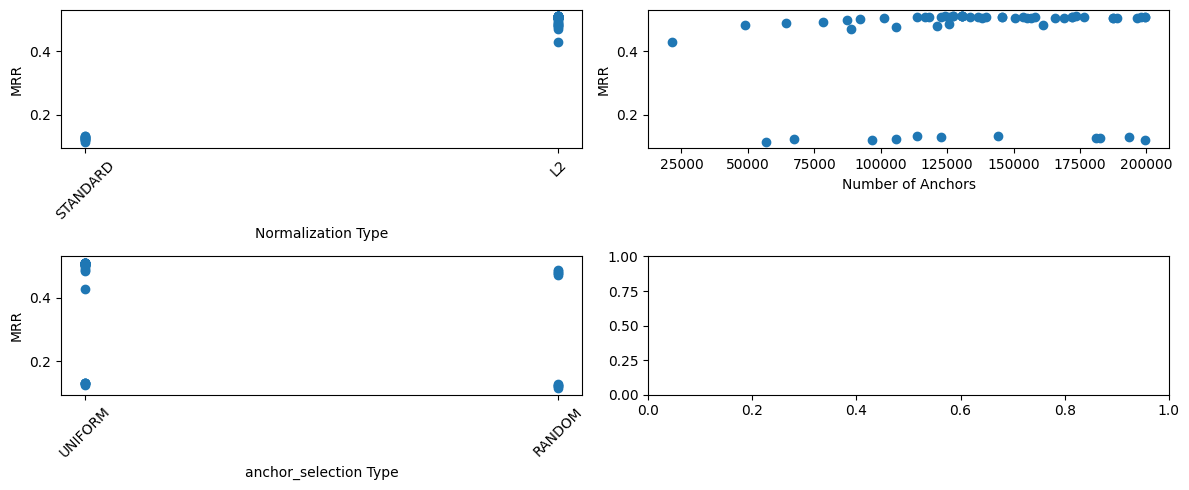

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 5))
ax[0][0].scatter(df['params_normalization'].apply(lambda x: x.name), df['value'])
ax[0][0].set_xlabel('Normalization Type')
ax[0][0].set_ylabel('MRR')
ax[0][0].tick_params(axis='x', rotation=45)

ax[0][1].scatter(df['params_n_anchors'], df['value'])
ax[0][1].set_xlabel('Number of Anchors')
ax[0][1].set_ylabel('MRR')

ax[1][0].scatter(df['params_anchor_selection'].apply(lambda x: x.name), df['value'])
ax[1][0].set_xlabel('anchor_selection Type')
ax[1][0].set_ylabel('MRR')
ax[1][0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ensembling models with VAE

### VAE

In [61]:
class VAEAdapter(nn.Module):
    """
    A simple VAE-based translator from text embeddings to image embeddings.

    Args:
        input_dim (int): Dimension of the input text embeddings.
        output_dim (int): Dimension of the output image embeddings.
        hidden_dim (int): Hidden layer width.
        latent_dim (int): Latent space dimensionality.
    """
    def __init__(self, input_dim, output_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )

    def reparameterize(self, mu, logvar):
        """Apply reparameterization trick."""
        return mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)

    def forward(self, x):
        """Forward pass: encode → sample → decode."""
        x = F.normalize(x, dim=-1)
        mu, logvar = self.encoder(x).chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return F.normalize(out, dim=-1), mu, logvar


def init_weights(m):
    """Kaiming initialization for all Linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

MODEL_REGISTRY = {"vae_adapter": VAEAdapter}

class VAELoss:
    """
    Combines CLIP-style reconstruction with VAE regularization.
    """
    def __init__(self, kld_weight=1e-3, device=DEVICE):
        self.kld_weight = kld_weight
        self.clip = ClipLoss().to(device)

    def __call__(self, pred, mu, logvar, y, logit_scale):
        y = F.normalize(y, dim=-1)
        recons = self.clip(image_features=y, text_features=pred, logit_scale=logit_scale)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        return recons + self.kld_weight * kld

@torch.inference_mode()
def validate_repo_metrics(model, data_keeper, val_gallery, val_labels, device=DEVICE):
    """
    Evaluate using the challenge’s official retrieval metrics (MRR, Recall@k, etc.).
    """
    model.eval()
    preds = [model(X.to(device))[0] for X, _ in tqdm(data_keeper.val_loader, desc="[Val: Metrics]")]
    preds = torch.cat(preds)
    return evaluate_retrieval(preds, data_keeper.val_img_embd, data_keeper.val_label, max_indices=100)

@torch.inference_mode()
def validate_cliploss(model, data_keeper, loss_fn, logit_scale, device=DEVICE):
    """
    Evaluate using internal CLIP-style reconstruction loss.
    """
    model.eval()
    val_loss = 0
    for X, y in tqdm(data_keeper.val_loader, desc="[Val: ClipLoss]"):
        X, y = X.to(device), y.to(device)
        pred, mu, logvar = model(X)
        val_loss += loss_fn(pred, mu, logvar, y, logit_scale).item()
    return {"val_loss": val_loss / len(data_keeper.val_loader)}

def train_model(model, data_keeper, epochs, loss_fn,lr=LR, device=DEVICE):
    """
    Train the model for one experiment run.
    Supports both normal training and Optuna trials.
    """
    logit_scale = nn.Parameter(torch.ones([], device=device) * np.log(1 / 0.07))
    optimizer = torch.optim.Adam(list(model.parameters()) + [logit_scale], lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in tqdm(data_keeper.train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred, mu, logvar = model(X)
            loss = loss_fn(pred, mu, logvar, y, logit_scale.exp().clamp(1, 100))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_keeper.train_loader)
        scheduler.step()
        tqdm.write(f"Epoch {epoch+1}: Average Train Loss = {avg_loss:.6f}")
    return model, logit_scale


In [69]:
data_keeper = get_train_data(split_ratio=0.9)

# {'hidden_dim': 1024, 'latent_dim': 2560, 'kld_weight': 0.0001, 'batch_size': 352}

data_keeper.create_loaders(352)

model = VAEAdapter(input_dim=1024, output_dim=1536, hidden_dim=1024, latent_dim=2560).to(DEVICE)
model.apply(init_weights)
loss_fn = VAELoss(kld_weight=0.0001, device=DEVICE)
model, logit_scale = train_model(model, data_keeper=data_keeper,epochs=10, loss_fn=loss_fn)

(125000,)
Train data: 125000 captions, 125000 images


Epoch 1/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 1: Average Train Loss = 2.875703


Epoch 2/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 2: Average Train Loss = 1.955466


Epoch 3/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 3: Average Train Loss = 1.528162


Epoch 4/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 4: Average Train Loss = 1.251978


Epoch 5/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 5: Average Train Loss = 1.047100


Epoch 6/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 6: Average Train Loss = 0.874160


Epoch 7/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 7: Average Train Loss = 0.730779


Epoch 8/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 8: Average Train Loss = 0.616570


Epoch 9/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 9: Average Train Loss = 0.535200


Epoch 10/10 [Train]:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 10: Average Train Loss = 0.493024


### ensembling

In [70]:
class DynamicEnsemble(nn.Module):
    def __init__(self, model1, model2, input_dim, hidden_dim=32):
        super().__init__()
        self.model1 = copy.deepcopy(model1)
        self.model2 = copy.deepcopy(model2)
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
        for param in self.model1.parameters():
          param.requires_grad = False
        for param in self.model2.parameters():
          param.requires_grad = False

    def forward(self, x):
        y1_output = self.model1(x)
        if isinstance(y1_output, tuple):
            y1 = y1_output[0]
        else:
            y1 = y1_output

        y2 = self.model2(x)

        w = F.softmax(self.gate(x), dim=1)
        y = w[:, 0:1] * y1 + w[:, 1:] * y2
        return y

In [71]:
class DynamicEnsembleV2(nn.Module):
    def __init__(self, model1, model2, input_dim=1024, output_dim=1536, hidden_dim=2048):
        super().__init__()
        self.model1 = copy.deepcopy(model1)
        self.model2 = copy.deepcopy(model2)
        self.gate_1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

        self.gate_2 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        for param in self.model1.parameters():
          param.requires_grad = False
        for param in self.model2.parameters():
          param.requires_grad = False

    def forward(self, x):
        y1_output = self.model1(x)
        if isinstance(y1_output, tuple):
            y1 = y1_output[0]
        else:
            y1 = y1_output

        y2 = self.model2(x)
        alpha = self.gate_1(x)
        beta = self.gate_2(x)
        combined = torch.stack((alpha, beta), dim=1)

        w = F.softmax(combined, dim=1)

        y = w[:, 0, :] * y1 + w[:, 1, :] * y2
        return y

In [72]:
class DynamicEnsembleSimple(nn.Module):
    def __init__(self, model1, model2):
        super().__init__()
        self.model1 = copy.deepcopy(model1)
        self.model2 = copy.deepcopy(model2)
        self.weights = nn.Parameter(torch.tensor([0.5, 0.5]))
        for param in self.model1.parameters():
          param.requires_grad = False
        for param in self.model2.parameters():
          param.requires_grad = False

    def forward(self, x):
        y1_output = self.model1(x)
        if isinstance(y1_output, tuple):
            y1 = y1_output[0]
        else:
            y1 = y1_output

        y2 = self.model2(x)
        w = F.softmax(self.weights, dim=0)
        y = w[0] * y1 + w[1] * y2
        return y

In [73]:
class DynamicEnsembleSimpleV2(nn.Module):
    def __init__(self, model1, model2, output_dim=1536):
        super().__init__()
        self.model1 = copy.deepcopy(model1)
        self.model2 = copy.deepcopy(model2)
        self.weights = nn.Parameter(torch.ones(2, output_dim) * 0.5)
        for param in self.model1.parameters():
          param.requires_grad = False
        for param in self.model2.parameters():
          param.requires_grad = False

    def forward(self, x):
        y1_output = self.model1(x)
        if isinstance(y1_output, tuple):
            y1 = y1_output[0]
        else:
            y1 = y1_output

        y2 = self.model2(x)

        w = F.softmax(self.weights, dim=0)
        y = w[0] * y1 + w[1] * y2
        return y

In [74]:
model_vae = model

In [75]:
ensenmble_model = DynamicEnsemble(model_vae, lotranslator, input_dim=1024).to(DEVICE)


In [76]:
ensenmble_model, metrics = train_model_affine(ensenmble_model, data_keeper.train_loader, epochs=10, verbose=True)

Trainnig:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 0.4305531675927341


Epoch 2/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.4305253243073821


Epoch 3/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.43053227458149196


Epoch 4/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.4305406273342669


Epoch 5/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.43053674874827264


Epoch 6/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.4305308544076979


Epoch 7/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.4305211783386767


Epoch 8/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.430531675554812


Epoch 9/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.4305360599420965


Epoch 10/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.43053094698116184


In [77]:
metrics = model_metrics(ensenmble_model, data_keeper)

In [78]:
print(metrics)

{'mrr': np.float64(0.44398665089565026), 'ndcg': np.float64(0.5542568787798516), 'recall_at_1': 0.29824, 'recall_at_3': 0.5148, 'recall_at_5': 0.62168, 'recall_at_10': 0.74688, 'recall_at_50': 0.91976}


In [79]:
ensenmble_model = DynamicEnsembleV2(model_vae, lotranslator, input_dim=1024, hidden_dim=320).to(DEVICE)


In [80]:
metrics = model_metrics(ensenmble_model, data_keeper)

In [81]:
print(metrics)

{'mrr': np.float64(0.5120853178747561), 'ndcg': np.float64(0.6128118940443429), 'recall_at_1': 0.368, 'recall_at_3': 0.59056, 'recall_at_5': 0.68576, 'recall_at_10': 0.80608, 'recall_at_50': 0.94464}


In [82]:
ensenmble_model = DynamicEnsembleSimpleV2(model_vae, lotranslator).to(DEVICE)


In [83]:
metrics = model_metrics(ensenmble_model, data_keeper)

In [84]:
ensenmble_model = DynamicEnsembleSimple(model_vae, lotranslator).to(DEVICE)


In [85]:
ensenmble_model, metrics = train_model_affine(ensenmble_model, data_keeper.train_loader, epochs=10, verbose=True)

Trainnig:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 0.4324842459522188


Epoch 2/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.4318298793397844


Epoch 3/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.4314004069194198


Epoch 4/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.4311275791376829


Epoch 5/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.43096949253231287


Epoch 6/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.43084688670933247


Epoch 7/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.4307747190818191


Epoch 8/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.43071763692423704


Epoch 9/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.4306800033897161


Epoch 10/10:   0%|          | 0/320 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.43066304717212917


In [86]:
metrics = model_metrics(ensenmble_model, data_keeper)

In [87]:
print(metrics)

{'mrr': np.float64(0.4477727551749538), 'ndcg': np.float64(0.5574411556003959), 'recall_at_1': 0.30304, 'recall_at_3': 0.51912, 'recall_at_5': 0.62552, 'recall_at_10': 0.74744, 'recall_at_50': 0.91872}


#### Coment

ensembling these models doesn't seems to bring any positive result